In [ ]:
#!pip install openeo
#!pip install rasterio

In [2]:

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

Conectarse al API usando los datos de usuario y contraseña

In [12]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=PRDI-JHXJ 📋 to authenticate.

❌ Timed out

OidcDeviceCodePollTimeout: Timeout (300.0s) while polling for access token.

In [ ]:
#Areas de interes
lago_atitlan = {
    "west": -91.31,
    "east": -91.08,
    "south": 14.60,
    "north": 14.74
}
lago_amatitlan = {
    "west": -90.66,
    "east": -90.58,
    "south": 14.43,
    "north": 14.51
}

Cargando las coordeanadas de Guatemala

In [ ]:
atitlan_cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=lago_atitlan,  # Región de Guatemala
    temporal_extent=["2025-08-01", "2025-08-03"],  # Usa fechas pasadas, no futuras
    bands=["B02","B03","B04", "B08"]
)

Descargar la imagen

In [ ]:
result_graph = atitlan_cube.save_result(format="GTIFF")
job = connection.create_job(result_graph)
job.start_and_wait()
job.download_results("../data/GIS/Bandas_Atitlan.tif")

Visualizar lo descargado

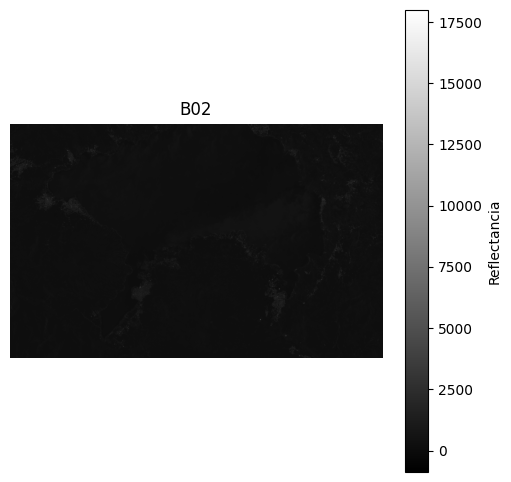

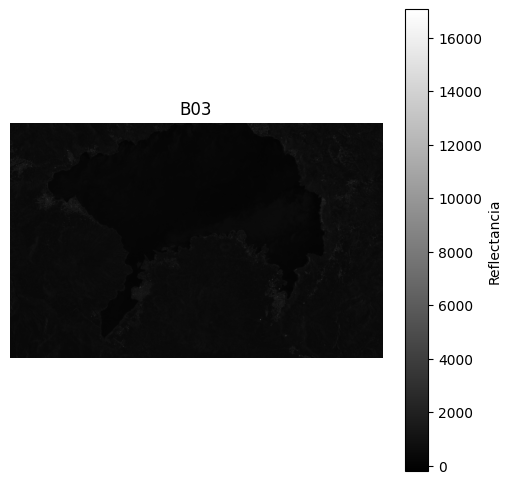

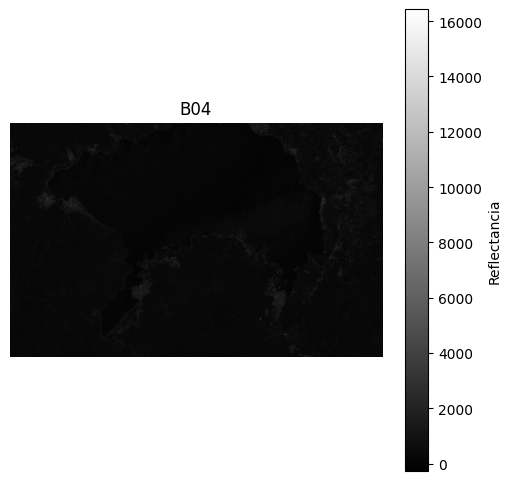

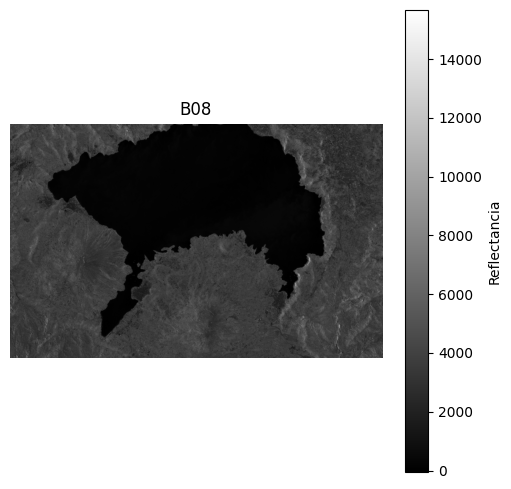

In [3]:
ruta_tif = "./Bandas_Atitlan.tif"

with rasterio.open(ruta_tif) as src:
    bandas = src.read()  # Lee todas las bandas
    nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
    nodata = src.nodata

# Visualizar bandas individuales
for i in range(bandas.shape[0]):
    plt.figure(figsize=(6, 6))
    img = bandas[i]
    img = np.ma.masked_where(img == nodata, img)
    plt.imshow(img, cmap='gray')
    plt.title(f"{nombres[i]}")
    plt.axis('off')
    plt.colorbar(label="Reflectancia")
    plt.show()

Mostrar en falso color

In [6]:
with rasterio.open("./Bandas_Atitlan.tif") as src:
    print("Número de bandas:", src.count)
    print("Descripciones:", src.descriptions)

Número de bandas: 4
Descripciones: ('B02', 'B03', 'B04', 'B08')


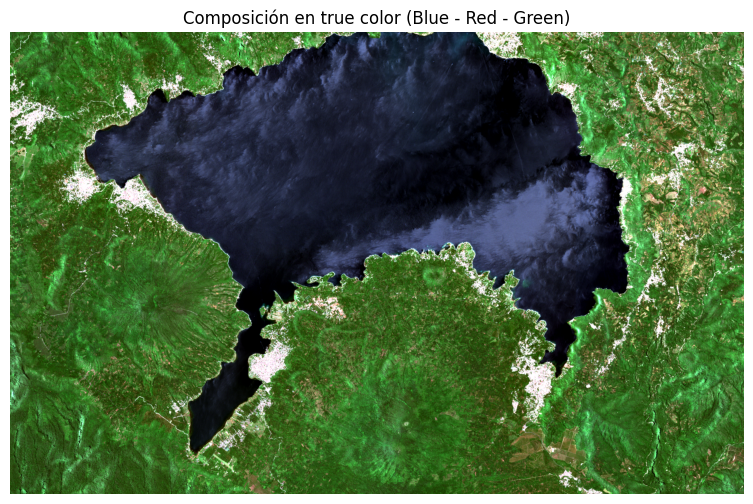

In [7]:
# Normalizador
def normalize(b):
    b_min, b_max = np.percentile(b[b > 0], (2, 98))
    return np.clip((b - b_min) / (b_max - b_min), 0, 1)

blue = bandas[0]   #B02
green = bandas[1]  # B03
red = bandas[2]    # B04
nir = bandas[3]    # B08

# Reasignar correctamente:
b = normalize(blue)  # B02
g = normalize(green)    # B03
r = normalize(red)    # B04
n = normalize(blue)    # B08

# Falso color (NIR, Red, Green)
rgb = np.dstack([r, g, b])

plt.figure(figsize=(10, 6))
plt.imshow(rgb)
plt.title("Composición en true color (Blue - Red - Green)")
plt.axis('off')
plt.show()


## NDVI

Calcule el índice de diferencia normalizada para el lago de Atitlán. Recuerde que usando Sentinel-2 se calcula usando las siguiente fórmula:<br>

NDVI (Sentinel 2) = (B8 – B4) / (B8 + B4)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Convertir a float32 y escalar a reflectancia (0–1)
red_scale = red.astype(np.float32) / 10000  # B04
nir_scale = nir.astype(np.float32) / 10000  # B08
green_scale = green.astype(np.float32) / 10000  # B08
blue_scale = blue.astype(np.float32) / 10000  # B08

# Calcular NDVI
ndvi_atitlan = np.where(
    (nir_scale + red_scale) == 0,
    0,
    (nir_scale - red_scale) / (nir_scale + red_scale)
)

ndvi_atitlan


C:\Users\mathew\AppData\Local\Temp\ipykernel_14828\2746701438.py:14: RuntimeWarning: divide by zero encountered in divide
  (nir_scale - red_scale) / (nir_scale + red_scale)


array([[0.8943977 , 0.88038284, 0.88805974, ..., 0.81519955, 0.80764776,
        0.77150923],
       [0.88217235, 0.87465936, 0.8712988 , ..., 0.8029633 , 0.7880333 ,
        0.8183684 ],
       [0.8826202 , 0.8887536 , 0.87438476, ..., 0.7838692 , 0.7857143 ,
        0.7940854 ],
       ...,
       [0.8845352 , 0.8969729 , 0.87696344, ..., 0.8388059 , 0.84798217,
        0.83227766],
       [0.8827925 , 0.8976744 , 0.8887779 , ..., 0.83270377, 0.85375303,
        0.85119045],
       [0.88245773, 0.89850754, 0.88834244, ..., 0.84452677, 0.85052687,
        0.8504384 ]], shape=(1570, 2491), dtype=float32)

### Visualizar NDVI

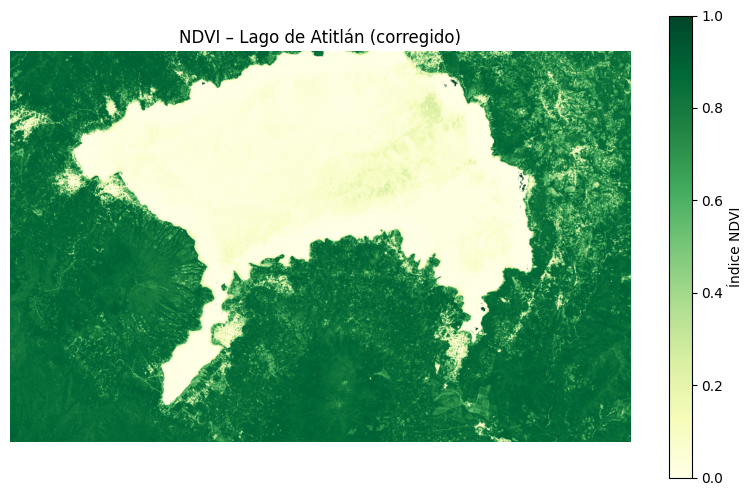

In [9]:
# Mostrar NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_atitlan, cmap='YlGn', vmin=0, vmax=1)
plt.title("NDVI – Lago de Atitlán (corregido)")
plt.colorbar(label="Índice NDVI")
plt.axis('off')
plt.show()

| NDVI          | Interpretación                                |
| ------------- | --------------------------------------------- |
| **0.6 a 1.0** | Vegetación muy densa y sana                   |
| **0.4 a 0.6** | Vegetación saludable (cultivos, bosques)      |
| **0.2 a 0.4** | Vegetación escasa o en estrés                 |
| **0.0 a 0.2** | Suelo desnudo, hierba seca                    |
| **< 0.0**     | Agua, nubes, nieve o superficies artificiales |


## NDWI
Calcule el índice de agua de diferencia normalizada (NDWI). Recuerde que se calcula usando la siguiente fórmula: <br>
NDWI (Sentinel 2) = (B3 – B8) / (B3 + B8)

In [10]:


ndwi_atitlan = np.where(
    (green_scale + nir_scale) == 0,
    0,
    (green_scale - nir_scale) / (green_scale + nir_scale)
)
ndwi_atitlan

array([[-0.80061245, -0.77828056, -0.7851473 , ..., -0.7104585 ,
        -0.71381485, -0.6746667 ],
       [-0.77007765, -0.7731958 , -0.77528095, ..., -0.706273  ,
        -0.6935197 , -0.7112506 ],
       [-0.77318114, -0.7975271 , -0.7827715 , ..., -0.69369376,
        -0.67670953, -0.7169812 ],
       ...,
       [-0.7517242 , -0.78644663, -0.74346507, ..., -0.73343563,
        -0.7439252 , -0.7326306 ],
       [-0.75000006, -0.774319  , -0.76039726, ..., -0.7308869 ,
        -0.73841965, -0.7517014 ],
       [-0.76608187, -0.7629938 , -0.7734311 , ..., -0.73273724,
        -0.7433057 , -0.7545233 ]], shape=(1570, 2491), dtype=float32)

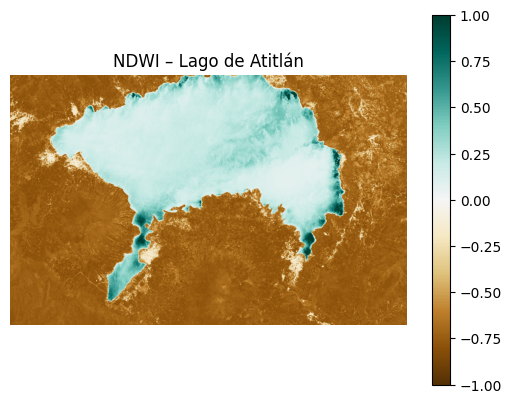

In [11]:
plt.imshow(ndwi_atitlan, cmap='BrBG', vmin=-1, vmax=1)
plt.title("NDWI – Lago de Atitlán")
plt.colorbar()
plt.axis('off')
plt.show()

| NDWI        | Interpretación                       |
| ----------- | ------------------------------------ |
| **> 0.2**   | Agua o zonas húmedas                 |
| **0 a 0.2** | Vegetación poco densa o suelo húmedo |
| **< 0**     | Vegetación o suelo seco              |


## Ejercicios:

1. Muestre el mapa en true color del lago de Amatitlan.  
2. Calcule los índices NDVI y NDWI para el lago de amatitlán y muestre los mapas.  
3. Discuta semejanzas y diferencias sobre los índices en ambos lagos